<a href="https://colab.research.google.com/github/ShahidHasib586/MIR-Deep-learning/blob/main/Questions_TP_horizon_segmentation_MIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Lab Assignment: Building a U-Net for Image Segmentation
Objective

The goal of this lab is to design and implement a U-Net neural network for image segmentation. The network will process infrared images captured by a camera mounted on an autonomous drone boat. The purpose of the segmentation task is to distinguish the sea from the sky. This segmentation will serve two primary purposes:  

*   Filtering out detections located in the sky.
*    Calculating the distance of a detection relative to the camera based on its distance from the horizon.
   

# Problem Context

Autonomous drone boats rely on visual data to make navigation and detection decisions. Infrared cameras are particularly useful in low-light or challenging environments, such as at night or during foggy conditions. However, to ensure accurate analysis, it is essential to segment the images to separate the sea from the sky.

In this lab, you will build and train a U-Net, a convolutional neural network architecture specifically designed for image segmentation tasks. The U-Net will label each pixel in the image as either "sea" or "sky." The resulting segmentation map will be used for filtering out false detections in the sky and estimating distances based on the location of the horizon.




# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

# Deliverables

1.   Python code for your U-Net implementation.
2.   The trained model (saved as a file)
3.   A report summarizing your findings and results ( plot evaluation loss, train loss and accuracy metric)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
'''import os
from zipfile import ZipFile

# List of ZIP files
zip_files = ['/content/drive/MyDrive/MIR/train_frames-20250112T192858Z-001.zip', '/content/drive/MyDrive/MIR/train_masks-20250112T192152Z-001.zip', '/content/drive/MyDrive/MIR/val_frames-20250112T193230Z-001.zip', '/content/drive/MyDrive/MIR/val_masks-20250112T193113Z-001.zip', '/content/drive/MyDrive/MIR/test_frames-20250112T193440Z-001.zip', '/content/drive/MyDrive/MIR/test_masks-20250112T193603Z-001.zip']  # Replace with your ZIP file names

# Destination folder for unzipped files
base_destination = '/content/MIR/datasets'

# Create the base destination folder if it doesn't exist
os.makedirs(base_destination, exist_ok=True)

# Loop through the ZIP files and extract each
for zip_file in zip_files:
    destination = os.path.join(base_destination, os.path.splitext(zip_file)[0])  # Folder named after the ZIP file
    os.makedirs(destination, exist_ok=True)  # Ensure the folder exists
    with ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination)  # Extract to the specific folder
    print(f"Extracted {zip_file} to {destination}")

# List all folders created
print("Unzipped folders:")
print(os.listdir(base_destination))'''


'import os\nfrom zipfile import ZipFile\n\n# List of ZIP files\nzip_files = [\'/content/drive/MyDrive/MIR/train_frames-20250112T192858Z-001.zip\', \'/content/drive/MyDrive/MIR/train_masks-20250112T192152Z-001.zip\', \'/content/drive/MyDrive/MIR/val_frames-20250112T193230Z-001.zip\', \'/content/drive/MyDrive/MIR/val_masks-20250112T193113Z-001.zip\', \'/content/drive/MyDrive/MIR/test_frames-20250112T193440Z-001.zip\', \'/content/drive/MyDrive/MIR/test_masks-20250112T193603Z-001.zip\']  # Replace with your ZIP file names\n\n# Destination folder for unzipped files\nbase_destination = \'/content/MIR/datasets\'\n\n# Create the base destination folder if it doesn\'t exist\nos.makedirs(base_destination, exist_ok=True)\n\n# Loop through the ZIP files and extract each\nfor zip_file in zip_files:\n    destination = os.path.join(base_destination, os.path.splitext(zip_file)[0])  # Folder named after the ZIP file\n    os.makedirs(destination, exist_ok=True)  # Ensure the folder exists\n    with ZipF

In [3]:
import os
project_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/"
data_set_path = "/content/drive/MyDrive/MIR/"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames-20250112T192858Z-001/train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks-20250112T192152Z-001/train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames-20250112T193230Z-001/val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks-20250112T193113Z-001/val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")


# Dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
2. why do we have to divide mask by 255?


1. Ans: The __getitem__ function in the HorizonDataset class is responsible for loading an image-mask pair from the dataset when requested. It is called automatically by the PyTorch DataLoader when iterating over the dataset during training. Inside __getitem__, the function retrieves the image and mask file paths using the provided index, opens them using PIL, converts them to NumPy arrays, and applies transformations if specified. This function ensures that each batch of data is correctly formatted before being fed into the model during training. It is used implicitly by the DataLoader when looping through batches in the training function.

2. Ans: The reason for dividing the mask by 255 is to normalize pixel values to a range between 0 and 1. Since mask images are usually stored in 8-bit format (values between 0 and 255), dividing by 255 converts them to a float format suitable for deep learning models, which typically expect inputs in a standardized range. This normalization helps improve numerical stability during training and allows the model to interpret the mask as a binary classification problem, where pixels closer to 1 represent the object of interest and pixels closer to 0 represent the background.

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

# Create a HorizonDataset class that derives from the pytorch Dataset class and complete the __getitem__(self, index) method.
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])

        # Open the image and mask using PIL
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB format
        mask = Image.open(mask_path).convert("L")   # Convert mask to grayscale

        # Convert to numpy arrays
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)

        # Normalize the mask values to [0, 1]
        mask = mask / 255.0

        # Apply augmentations (if any)
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return (image, mask)


## Loader definition
Questions:
1. Explain what the data loader is for?

Ans: The DataLoader in PyTorch is responsible for efficiently loading and managing batches of data during training and evaluation. It takes a dataset (such as the HorizonDataset class) and provides functionalities like batching, shuffling, and parallel data loading using multiple workers. Instead of loading all the data into memory at once, the DataLoader fetches small batches at a time, which improves computational efficiency and allows training on large datasets that wouldn't fit entirely in memory.

During training, the DataLoader ensures that each batch is fed into the model in a structured way, handling indexing through __getitem__ and organizing the data into mini-batches. If shuffling is enabled, it randomly rearranges the dataset in each epoch to reduce bias and improve model generalization. For validation and testing, shuffling is typically disabled to maintain a consistent order for evaluation. The DataLoader significantly simplifies dataset handling, making deep learning training more scalable and efficient.

In [6]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
# for training shuffel should be true in this case, we shaffle the training set to reduce Bias in training, to improve Gradient Descent efficiency, to avoid temporal or positional correlations, it also ensures better generalization in the training set. However, if we are working with time series data we wont shaffel as it will destroy the specific pettern.
    train_loader =  DataLoader(train_ds, shuffle=True,
                               batch_size=batch_size,
                               pin_memory = pin_memory ,num_workers=num_workers)

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
# Warning to shuffle (true or false ??? explain why in commentary)
# We dont shaffle the Validation and testing datasets. These data should not be shuffled to maintain consistency in evaluation. we also don't do that for the time series data: If the order of data has temporal significance, shuffling might destroy important patterns. Use sequence-specific techniques in such cases.
    val_loader = DataLoader(val_ds, shuffle=False,
	  batch_size=batch_size, pin_memory=pin_memory,
	  num_workers=num_workers)

    return train_loader, val_loader

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

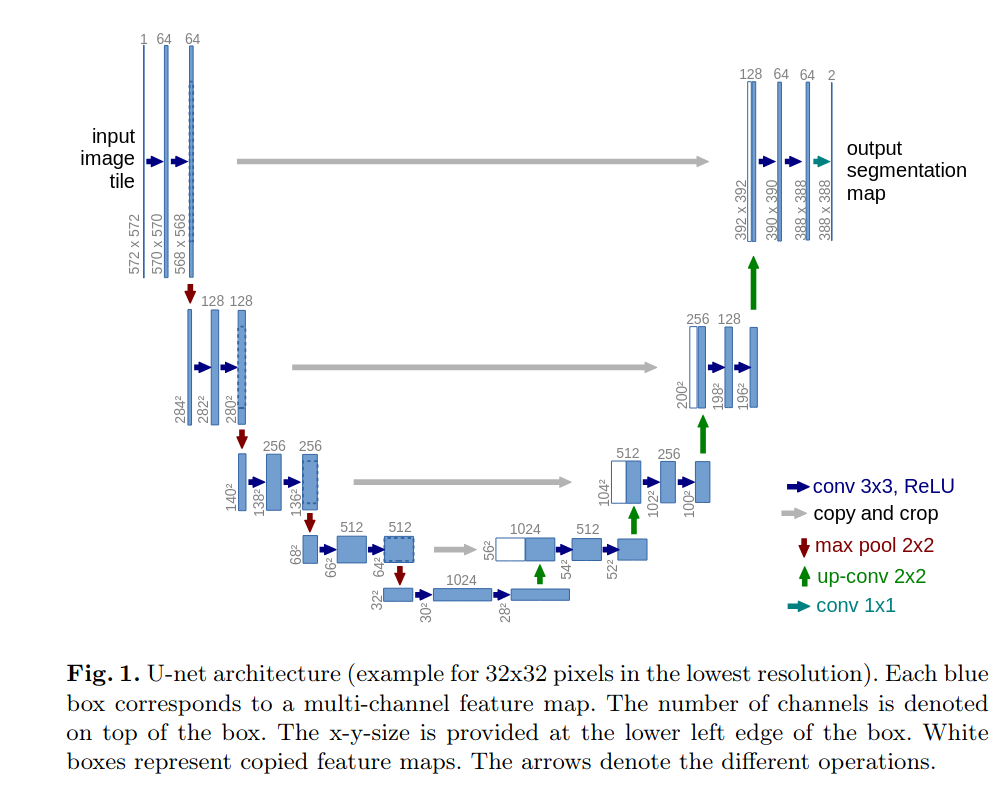

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
#The code belolow will look for GPU if it finds a GPU it will run the code using GPU otherwise it will run the code on CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

In [8]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [9]:
# The same but with only one sequence
class SingleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [10]:
import torch.nn as nn

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Bottleneck
        self.bottleneck = SingleConv(features[-1], features[-1] * 2)

        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

In [11]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()  # put the model in evaluation mode

    '#TODO'
    # Use torch.no_grad() to disable gradient tracking during validation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # Make predictions using the model
            preds = model(x)

            # Convert predictions to a binary mask (thresholding)
            preds = torch.sigmoid(preds)  # Apply sigmoid activation to get probabilities
            preds = (preds > 0.5).float()  # Thresholding: values > 0.5 become 1, else 0

            # As 'y' is a single-channel binary mask
            if y.shape[-1] == 3:
                y = y[..., 0].unsqueeze(1)  # Take the first channel and add the channel dimension

            # Calculate evaluation metrics (Dice coefficient and accuracy)
            num_correct += (preds == y).sum()  # Count the number of correct pixels
            num_pixels += torch.numel(preds)  # Count the total number of pixels
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) # Add 1e-8 to avoid division by zero

    # Calculate validation accuracy (Dice coefficient) over the entire validation dataset
    val_accuracy = dice_score / len(loader)
    '#TODO'

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels:.2f}%"
    )
    print(f"Dice score: {val_accuracy}")
    model.train()  # put the model back in training mode

    return val_accuracy

# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [12]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Hyper parameters

In [13]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size, epoch_numbers, device="cuda"):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers
        self.device = device  # Added device as an attribute


## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()


In [14]:
def check_val_loss(loader, model, loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()  # Set the model to evaluation mode to disable certain layers like dropout and batch normalization during inference.

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.float().unsqueeze(1).to(device)  # Move input data and targets to the specified device (GPU or CPU).
            outputs = model(data)  # Perform inference to obtain model predictions.
            loss = loss_fn(outputs, targets)  # Calculate the loss between predictions and ground truth targets.
            totalValLoss += loss.item()  # Accumulate the validation loss for all batches.

    val_loss = totalValLoss / len(loader)  # Calculate the average validation loss over the entire validation dataset.

    print(f"Val loss: {val_loss}")
    model.train()  # Set the model back to training mode with enabled layers like dropout and batch normalization.

    return val_loss

def save_eval(loader, model, epoch, file_path="eval_image", device="cuda"):

    model.eval()  # Set the model to evaluation mode to disable certain layers like dropout and batch normalization during inference.

    with torch.no_grad():
        val_images, val_masks = next(iter(loader))  # Get a batch of validation images and masks.
        val_images = val_images.to(device)  # Move validation images to the specified device (GPU or CPU).
        filename = file_path + "_" + str(epoch)
        predictions = model(val_images)  # Obtain model predictions (logits).
        preds = torch.sigmoid(predictions)  # Apply sigmoid activation to obtain probability maps.

        # Extract individual numpy arrays for visualization.
        image = val_images[0][0].cpu().numpy()  # Extract the first image from the batch.
        mask = val_masks[0].cpu().numpy()  # Extract the corresponding ground truth mask.
        pred_mask = preds[0, 0, :, :].cpu().numpy()  # Extract the predicted mask from the probability map.

        # Create subplots to visualize the original image, ground truth, and predicted mask.
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Base Mask')
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title('Predicted Mask')

        # Add a title to the entire figure.
        fig.suptitle(f'Image, Base Mask, and Predicted Mask for epoch: {epoch}')

        # Save the figure as an image file.
        plt.savefig(f"{filename}_sample.png")
        plt.close()
        # This code extracts a single image and its corresponding mask from the data loader, feeds it through the model to obtain predictions,
        # and then visualizes the original image, ground truth mask, and predicted mask using matplotlib.

    model.train()  # Set the model back to training mode with enabled layers like dropout and batch normalization.


In [15]:
from tqdm import tqdm

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, total=len(loader), unit="batch")
    totalTrainLoss = 0.0

    # Loop through batches of data and targets
    for batch_idx, (data, targets) in enumerate(loop):
        # Move data and targets to the specified device (usually GPU)
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE).unsqueeze(1)

        # Perform forward pass through the neural network model
        with torch.cuda.amp.autocast():
            predictions = model(data)  # Get model predictions for the batch
            loss = loss_fn(predictions, targets)  # Calculate the loss for this batch
            totalTrainLoss += loss  # Accumulate the total training loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear any previous gradients before backpropagation
        scaler.scale(loss).backward()  # Scale the loss to avoid gradient underflow and perform backpropagation
        scaler.step(optimizer)  # Update model weights using the optimizer
        scaler.update()  # Update the gradient scaler for dynamic loss scaling

        # Update the progress bar (tqdm loop) to display the current loss
        loop.set_postfix(loss=loss.item(), refresh=False)
        loop.update()

    loop.close()  # Close the tqdm loop

    train_loss = totalTrainLoss/len(loader)
    print(f"Train loss: {train_loss}")

    return train_loss

## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?

1. Why are transformations missing for validation data?
Transformations such as random rotation, flipping, and augmentation are applied to training data to introduce variability and improve the model’s generalization. However, for validation data, we do not apply these transformations because validation serves as a benchmark for model performance. If we modify the validation data, it will no longer reflect real-world conditions, leading to an inconsistent evaluation of the model's ability to generalize. The validation dataset should remain unchanged to provide a fair and stable measure of the model’s performance across different training iterations.

2. Why is nn.BCEWithLogitsLoss() used instead of classical BCE?
nn.BCEWithLogitsLoss() is used instead of the classical Binary Cross-Entropy (BCE) because it combines the sigmoid activation function with BCE loss in a single, numerically stable operation. When using standard BCE loss, you must manually apply a sigmoid activation to your model’s outputs before computing the loss. However, doing so separately can lead to numerical instability, especially for extreme values. BCEWithLogitsLoss() internally applies sigmoid, preventing vanishing gradients and improving numerical precision, making it the preferred choice for binary classification tasks.

3. Comment on torch.cuda.amp.GradScaler()
torch.cuda.amp.GradScaler() is a feature in Automatic Mixed Precision (AMP) that helps improve training efficiency when using half-precision (float16) computations. Normally, deep learning models use float32 (single-precision), but AMP allows certain operations to be performed in float16, reducing memory consumption and improving GPU performance. However, using float16 can sometimes cause numerical underflow, where very small gradients become zero. GradScaler() dynamically scales up the gradients to prevent underflow, ensuring stable training while taking advantage of mixed-precision speedup.

4. What is Adam? What’s the main difference between Adam and SGD?
Adam (Adaptive Moment Estimation) is an adaptive optimization algorithm that combines the benefits of momentum-based optimization (like SGD with momentum) and RMSprop (adaptive learning rates). It uses two moving averages:

First moment estimate (mean of past gradients)
Second moment estimate (uncentered variance of past gradients)
The main difference between Adam and Stochastic Gradient Descent (SGD) is:

SGD updates weights using the same learning rate for all parameters, which can make convergence slower and sensitive to learning rate choices.
Adam adapts the learning rate individually for each parameter based on past gradients, making it more suitable for noisy datasets and non-stationary objectives.


In [16]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Results:
    def __init__(self, file_path="results"):
        self.result_dict = {
            "train_loss": [],
            "val_loss": [],
            "val_acc": []
        }
        self.path = file_path

    def add_result(self, train_loss, val_loss, val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

    def plotAndSave(self, n_epoch):
        filename = self.path + "_" + str(n_epoch)
        plt.figure(figsize=(10, 4))

        # Ensure each element in the lists is a PyTorch tensor, detach, and move to CPU
        train_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["train_loss"]]
        val_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_loss"]]
        val_acc_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_acc"]]

        plt.subplot(1, 3, 1)
        plt.plot(np.arange(n_epoch + 1), train_loss_cpu, label='Train Loss')
        plt.title('Train Loss')

        plt.subplot(1, 3, 2)
        plt.plot(np.arange(n_epoch + 1), val_loss_cpu, label='Validation Loss')
        plt.title('Validation Loss')

        plt.subplot(1, 3, 3)
        plt.plot(np.arange(n_epoch + 1), val_acc_cpu, label='Validation Accuracy')
        plt.title('Validation Accuracy')

        plt.legend()
        plt.savefig(f'{filename}.png')
        plt.show()

In [17]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    torch.save(state, filename)

# Define a function to load a checkpoint and update the model's state.
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

# Define the main training function, which takes hyperparameters as input.
def run_training(hyper_parameters):
    # Create an object to store and visualize training results.
    results = Results(file_path=PLOT_PATH)

    # Define data augmentation transformations for training images.
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),  # Resize images to a fixed size
        A.Rotate(limit=35, p=1.0),  # Randomly rotate images
        A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally
        A.VerticalFlip(p=0.1),  # Randomly flip images vertically
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),  # Normalize images with mean and standard deviation
        ToTensorV2(),  # Convert images to tensors
    ])

    # Define data augmentation transformations for validation images.
    val_transforms = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),  # Resize images to a fixed size
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),  # Normalize images with mean and standard deviation
        ToTensorV2(),  # Convert images to tensors
    ])

#     # Create an instance of the UNET model and move it to the specified device (usually GPU).
#     model = UNET().to(DEVICE)
#     # Define the loss function for training.
#     loss_fn = nn.BCEWithLogitsLoss()
#     # Define the optimizer (Adam) with the specified learning rate.
#     optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)


    model = UNET(in_channels=3, out_channels=1).to(device=DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    # Create data loaders for training and validation datasets.
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    # If a saved model checkpoint exists, load it.
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    # Check the accuracy of the model on the validation dataset.
    check_accuracy(val_loader, model, device=DEVICE)

    # Create a gradient scaler for mixed-precision training (used later in the loop).
    scaler = torch.cuda.amp.GradScaler()

    # Loop through training epochs.
    for epoch in range(hyper_parameters.epoch_numbers):
        # Train the model for one epoch and calculate the training loss.
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # Save the model's state and optimizer parameters as a checkpoint.
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_PATH)

        # Save evaluation results, including validation images with predictions.
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device=DEVICE)

        # Calculate the validation loss.
        val_loss = check_val_loss(val_loader, model, loss_fn)

        # Calculate the accuracy on the validation dataset.
        val_accuracy = check_accuracy(val_loader, model, device="cuda")

        # Add the training and validation results to the results object.
        results.add_result(train_loss, val_loss, val_accuracy)

        # Plot and save the results for the current epoch.
        results.plotAndSave(epoch)

        # Save evaluation results again for good measure.
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device="cuda")

    # Return the trained model.
    return model

# Run Training

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-17-046804269046>:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Got 235565152/117800960 with acc 2.00%
Dice score: 0.0


  0%|          | 0/1247 [00:00<?, ?batch/s]<ipython-input-15-933600af76b4>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 1247/1247 [39:22<00:00,  1.89s/batch, loss=0.0068]


Train loss: 0.06096924468874931
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.030110361249299018
Got 445797534/117800960 with acc 3.78%
Dice score: 0.949154257774353


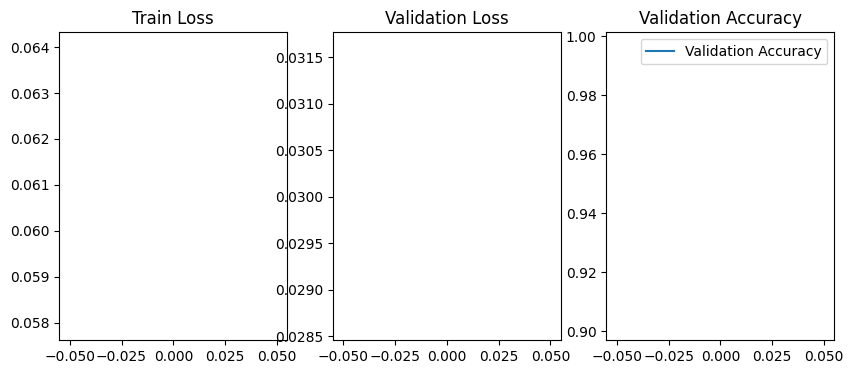

100%|██████████| 1247/1247 [01:33<00:00, 13.27batch/s, loss=0.0182]


Train loss: 0.021491074934601784
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.013484085428562675
Got 447792615/117800960 with acc 3.80%
Dice score: 0.9534675478935242


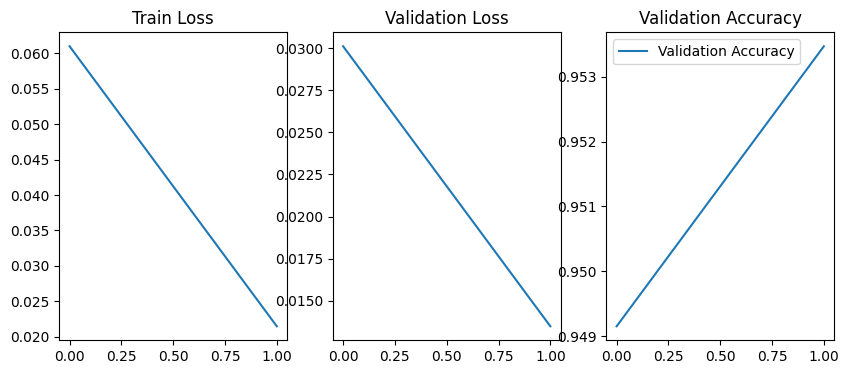

100%|██████████| 1247/1247 [01:33<00:00, 13.30batch/s, loss=0.0173]


Train loss: 0.016044514253735542
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.011872846354265283
Got 448103696/117800960 with acc 3.80%
Dice score: 0.9541097283363342


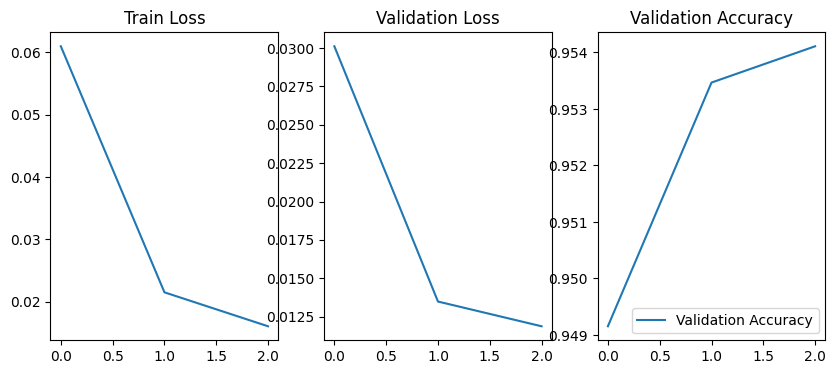

100%|██████████| 1247/1247 [01:33<00:00, 13.34batch/s, loss=0.00675]


Train loss: 0.013404267840087414
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008366377208924731
Got 448199363/117800960 with acc 3.80%
Dice score: 0.9543293714523315


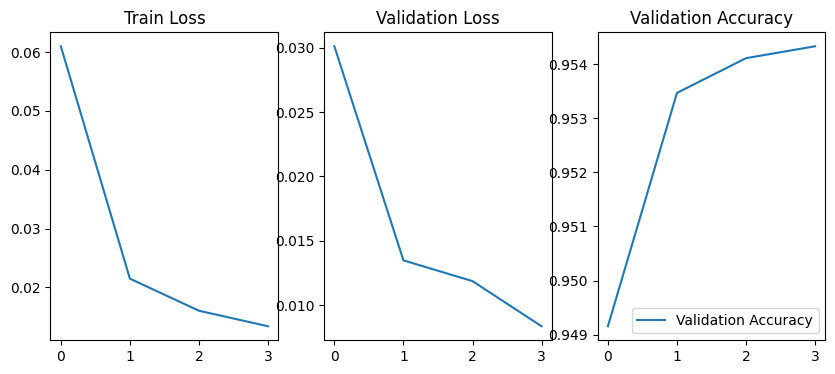

100%|██████████| 1247/1247 [01:33<00:00, 13.28batch/s, loss=0.00525]


Train loss: 0.012320623733103275
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.007475788998484893
Got 448363995/117800960 with acc 3.81%
Dice score: 0.9546438455581665


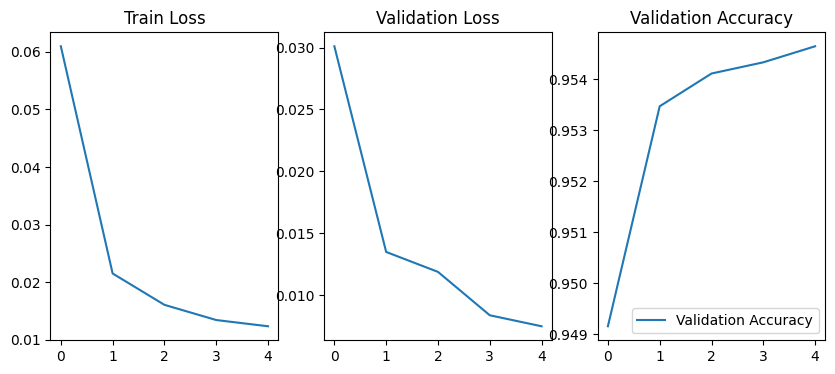

100%|██████████| 1247/1247 [01:34<00:00, 13.14batch/s, loss=0.00642]


Train loss: 0.010138462297618389
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008062787665037627
Got 448228532/117800960 with acc 3.80%
Dice score: 0.9543534517288208


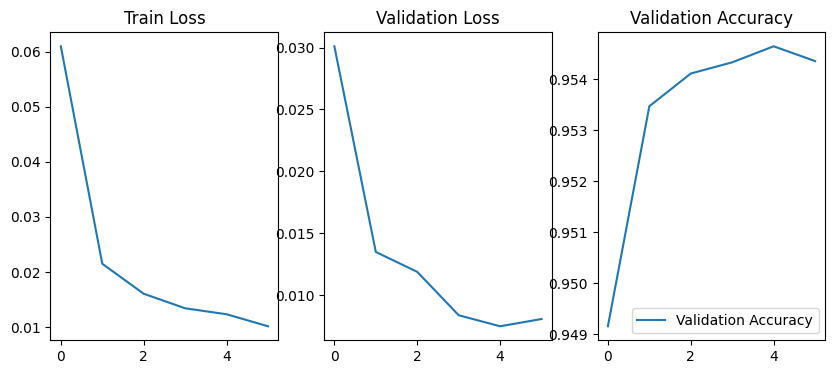

100%|██████████| 1247/1247 [01:33<00:00, 13.31batch/s, loss=0.00579]


Train loss: 0.010593063198029995
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008285859202809664
Got 448229175/117800960 with acc 3.80%
Dice score: 0.9544001221656799


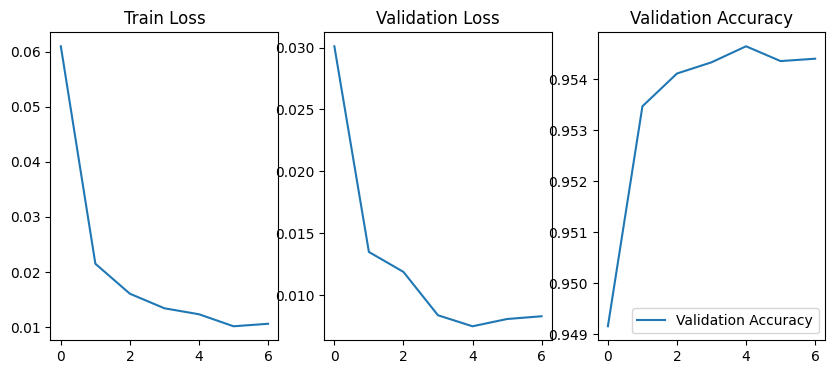

100%|██████████| 1247/1247 [01:32<00:00, 13.41batch/s, loss=0.00689]


Train loss: 0.009523632004857063
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.007353982590325384
Got 448254798/117800960 with acc 3.81%
Dice score: 0.9544621109962463


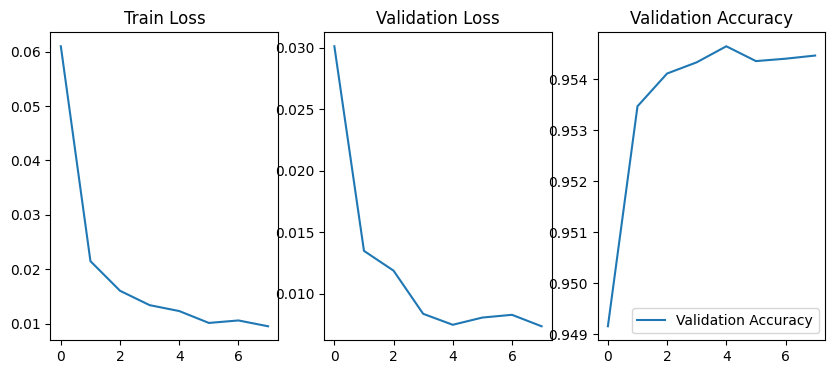

100%|██████████| 1247/1247 [01:35<00:00, 13.07batch/s, loss=0.00475]


Train loss: 0.008202179335057735
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.0063843669953058835
Got 448367004/117800960 with acc 3.81%
Dice score: 0.9546639323234558


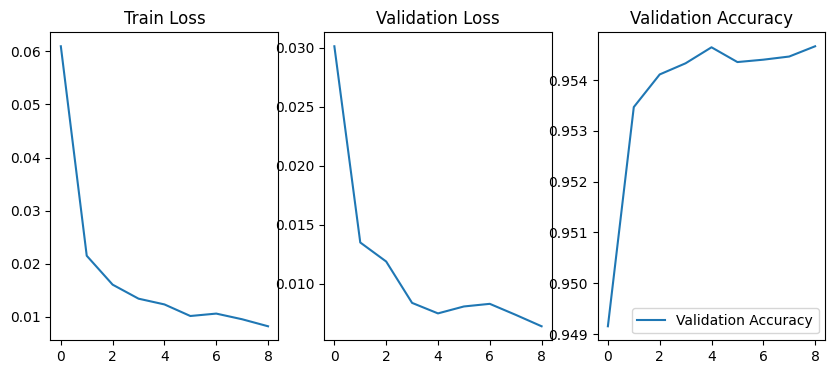

100%|██████████| 1247/1247 [01:35<00:00, 13.08batch/s, loss=0.0061]


Train loss: 0.008378942497074604
=> Saving checkpoint: 
/content/drive/MyDrive/Colab Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.006262626686056784
Got 448400403/117800960 with acc 3.81%
Dice score: 0.9547375440597534


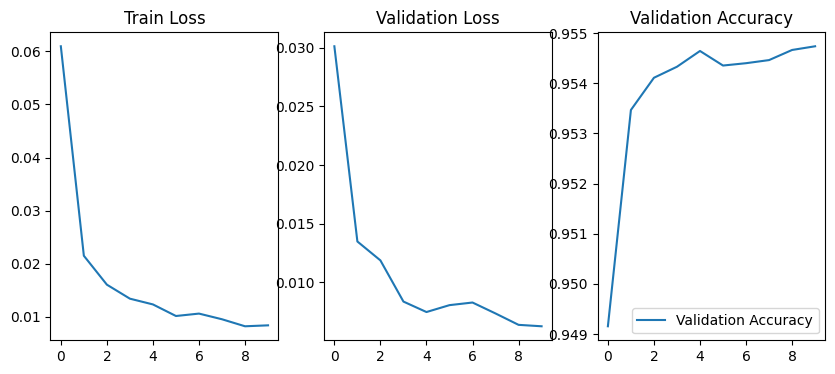

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNor

In [18]:

# Define hyperparameters with the corrected class
hyper_parameters = HyperParameters(learning_rate=1e-4, batch_size=4, epoch_numbers=10, device="cuda")

# Run the training function
run_training(hyper_parameters)


# Evaluation

=> Loading checkpoint


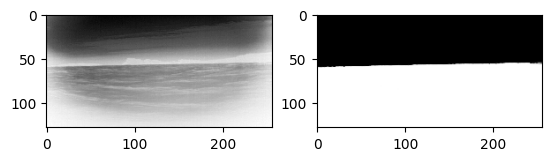

In [22]:
# Initialize the model
model = UNET(in_channels=3, out_channels=1).to(device=DEVICE)

# Load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, weights_only=True)
load_checkpoint(checkpoint, model)

# Validation transformations
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

# Validation dataset and loader
val_ds = HorizonDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=val_transforms,
)
val_loader = DataLoader(
    val_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=True,
    shuffle=False,
)

# Get a batch of validation images and masks
val_images, val_masks = next(iter(val_loader))

# Move images to the appropriate device and get predictions
data = val_images.to(device=DEVICE)
with torch.no_grad():
    y = model(data)

# Apply sigmoid activation and convert predictions to NumPy
preds = torch.sigmoid(y).cpu().numpy()

# Visualize the input image and its predicted mask
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(val_images[1][0].cpu().numpy(), cmap="gray")  # Input image
f.add_subplot(1, 2, 2)
plt.imshow(preds[1][0], cmap="gray")  # Predicted mask
plt.show(block=True)